In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import io
import tensorflow as tf
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
cnt = 10;
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if cnt>0:
            cnt = cnt-1
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg


In [30]:
torch.manual_seed(42) #to ensure reporducability
if torch.cuda.is_available:
    print("cuda is available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.cuda.manual_seed(42)


import torch.multiprocessing as mp

if __name__ == '__main__':
    mp.set_start_method('spawn')

cuda is available


In [31]:
#transforms for images
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [32]:
dataset = datasets.ImageFolder("../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset", train_transforms)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


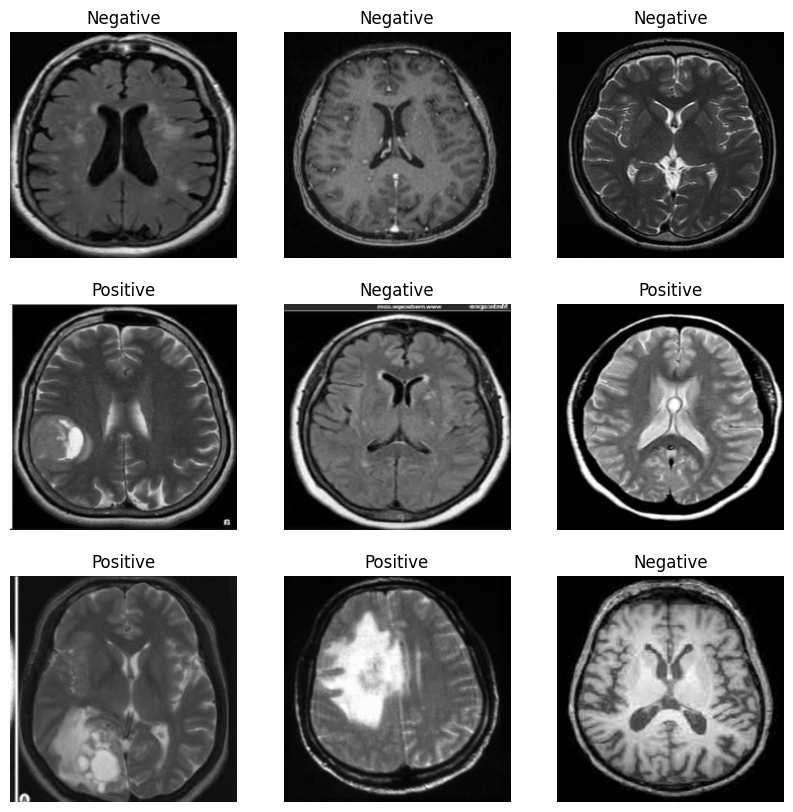

In [33]:
#load data
dataiter = iter(dataloader)
X,Y = next(dataiter)
classes = {0: 'Negative', 1: 'Positive'}
fig,axes = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        plt.sca(axes[i,j])
        idx = np.random.randint(0,31)
        image = np.moveaxis(X[idx].numpy(),0,2)
        print(image.shape)
        plt.title(classes[Y[idx].item()])
        plt.imshow(image,cmap='gray')
        plt.axis('off')

In [34]:
#defining convolutional block
def convBlock(ni, no):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.Conv2d(no, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

In [35]:
#defining the model layers
class CancerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = convBlock(1, 32)
        self.conv2 = convBlock(32, 64)
        self.conv3 = convBlock(64, 128)
        self.conv4 = convBlock(128, 256)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 128)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [36]:
#loading model onto device
model = CancerClassifier().to(device)
print(model)

CancerClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [37]:
print(len(dataset))
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
print(optimizer)

253
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [38]:
nepochs = 20
overall_accuracy = 0
for epoch in range(nepochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for images,labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    accuracy = total_correct / total_samples
    overall_accuracy = max(accuracy , overall_accuracy)
    print(f"Epoch [{epoch+1}/{nepochs}], Loss: {total_loss/len(dataloader):.4f}, Accuracy: {accuracy:.4f}")
    

Epoch [1/20], Loss: 0.6793, Accuracy: 0.6087
Epoch [2/20], Loss: 0.5620, Accuracy: 0.7470
Epoch [3/20], Loss: 0.4973, Accuracy: 0.7826
Epoch [4/20], Loss: 0.5240, Accuracy: 0.7787
Epoch [5/20], Loss: 0.5010, Accuracy: 0.7826
Epoch [6/20], Loss: 0.4659, Accuracy: 0.7945
Epoch [7/20], Loss: 0.4183, Accuracy: 0.8063
Epoch [8/20], Loss: 0.4291, Accuracy: 0.8221
Epoch [9/20], Loss: 0.4224, Accuracy: 0.8300
Epoch [10/20], Loss: 0.4060, Accuracy: 0.8340
Epoch [11/20], Loss: 0.3609, Accuracy: 0.8735
Epoch [12/20], Loss: 0.3188, Accuracy: 0.8775
Epoch [13/20], Loss: 0.2959, Accuracy: 0.8814
Epoch [14/20], Loss: 0.2876, Accuracy: 0.8854
Epoch [15/20], Loss: 0.2830, Accuracy: 0.8656
Epoch [16/20], Loss: 0.3044, Accuracy: 0.8577
Epoch [17/20], Loss: 0.2717, Accuracy: 0.8972
Epoch [18/20], Loss: 0.2682, Accuracy: 0.9012
Epoch [19/20], Loss: 0.2917, Accuracy: 0.8814
Epoch [20/20], Loss: 0.2909, Accuracy: 0.8775


In [39]:
print("Best accuracy: ",round(overall_accuracy*100,2),"%")
torch.save(model.state_dict(), "brain_cancer_classifier.pth")

Best accuracy:  90.12 %


In [49]:
def predict_and_draw(image_bytes):
    # Load the image bytes into a numpy array
    image_np = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_np, flags=cv2.IMREAD_COLOR)
    
    # Resize and convert the image to grayscale
    image = cv2.resize(image, (256, 256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0
    
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        predicted = torch.argmax(output, dim=1)
    
    # Move the image back to CPU for further processing and convert to NumPy array
    image = image.squeeze().cpu().numpy()
    
    # Convert the image back to 8-bit grayscale for further use
    image_np = np.uint8(image * 255)
    
    # Convert the grayscale image to a BGR image
    image_with_square = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

    # Return the predicted class and the processed image
    return ("Tumor" if predicted.item() == 1 else "No Tumor", image_with_square)


Predicted Class: Tumor


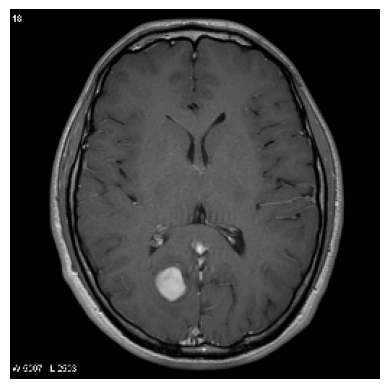

In [50]:
with open("../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y6.jpg", "rb") as f:
    image_bytes = f.read()
    predicted_class, image_with_square = predict(image_bytes)
    print("Predicted Class:", predicted_class)
    plt.imshow(image_with_square, cmap='gray')
    plt.axis('off')
    plt.show()